In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('lib')
from lib.read_data import *
import os

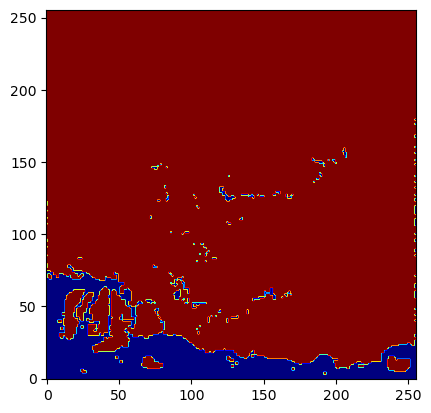

In [2]:
N = 256
frame = 100
dir = f"{DATA_PATH}/dambreak_N{N}_200"
flags = read_flags(f"{dir}/flags_{frame}.bin")
plt.imshow(flags.reshape(N, N).T, origin='lower', cmap='jet')
plt.show()

In [3]:
from scipy.ndimage import label
structure = np.ones((3, 3))
labeled, ncomponents = label((flags == 2).reshape(N, N), structure)

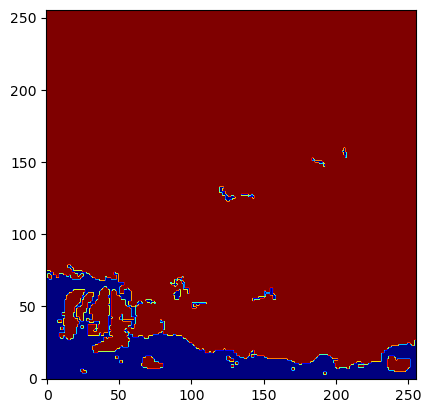

In [4]:
window_size = 9
for i in range(1, ncomponents+1):
    label1 = np.where(labeled == i)
    if len(label1[0]) < 9:
        labeled[label1] = 0
flags_denoised = np.where(labeled == 0, 3, 2)
plt.imshow(flags_denoised.reshape(N, N).T, origin='lower', cmap='jet')
plt.show()

In [5]:
from lib.create_dataset import *

flags_denoised = flags_denoised.ravel()

rhs = load_vector(f"{dir}/div_v_star_{i}.bin", dtype='d')
rhs_denoised = np.where(flags_denoised==2, flags_denoised, 0.0)
A = readA_sparse(f"{dir}/A_{i}.bin", dtype='d')

len(np.argwhere(rhs ==0)), len(np.argwhere(rhs_denoised == 0))

(58994, 59096)

In [6]:
num_ritz_vectors = 800

A_comp = compressedMat(A, flags_denoised)
rhs_de_comp = compressedVec(rhs_denoised, flags_denoised)
ritz_vals, ritz_vec = createRitzVec(A_comp, rhs_de_comp, num_ritz_vectors)

Lanczos Iteration is running...
Lanczos Iteration took 1.6728947162628174 s
Calculating eigenvectors of the tridiagonal matrix
Calculating eigenvectors took 0.029011964797973633 s


In [7]:
out = f"{dir}/preprocessed/{frame}"
os.makedirs(out, exist_ok=True)
fp = np.memmap(f"{out}/ritz_{num_ritz_vectors}.dat", dtype=np.float32, mode='w+', shape=ritz_vec.shape)
fp[:] = ritz_vec
fp.flush()

In [8]:
import torch

torch.save(torch.tensor(flags_denoised, dtype=torch.float32), os.path.join(out, "flags_denoised.pt"))

/home/wlan/miniforge3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
sample_size = 800
theta = 200 # j < m/2 + theta low frequency spectrum

fluid_cells = np.where(flags_denoised == 2)[0]
b_rhs_temp = np.zeros([sample_size, len(fluid_cells)])
cut_idx = int(num_ritz_vectors/2) + theta
sample_size = sample_size
coef_matrix = np.zeros([len(ritz_vec), sample_size])
coef_matrix[:] = np.random.normal(0, 1, [len(ritz_vec), sample_size])
coef_matrix[0:cut_idx] *= 9
b_rhs_temp[:] = coef_matrix.T @ ritz_vec
for i in range(sample_size):
    b_rhs_temp[i] = b_rhs_temp[i]/np.linalg.norm(b_rhs_temp[i])
    b = torch.zeros(N**2, dtype=torch.float32)
    b[fluid_cells] = torch.tensor(b_rhs_temp[i], dtype=torch.float32)
    # s = sparse.coo_matrix((b_rhs_temp[i-l_b], (padding, np.zeros_like(padding))), shape=flags.shape+(1,), dtype=np.float32)
    torch.save(b, os.path.join(out, f"b_{i}_denoised.pt"))

ValueError: could not broadcast input array from shape (800,6440) into shape (800,6638)